--- 1. Data Loading and Preprocessing ---


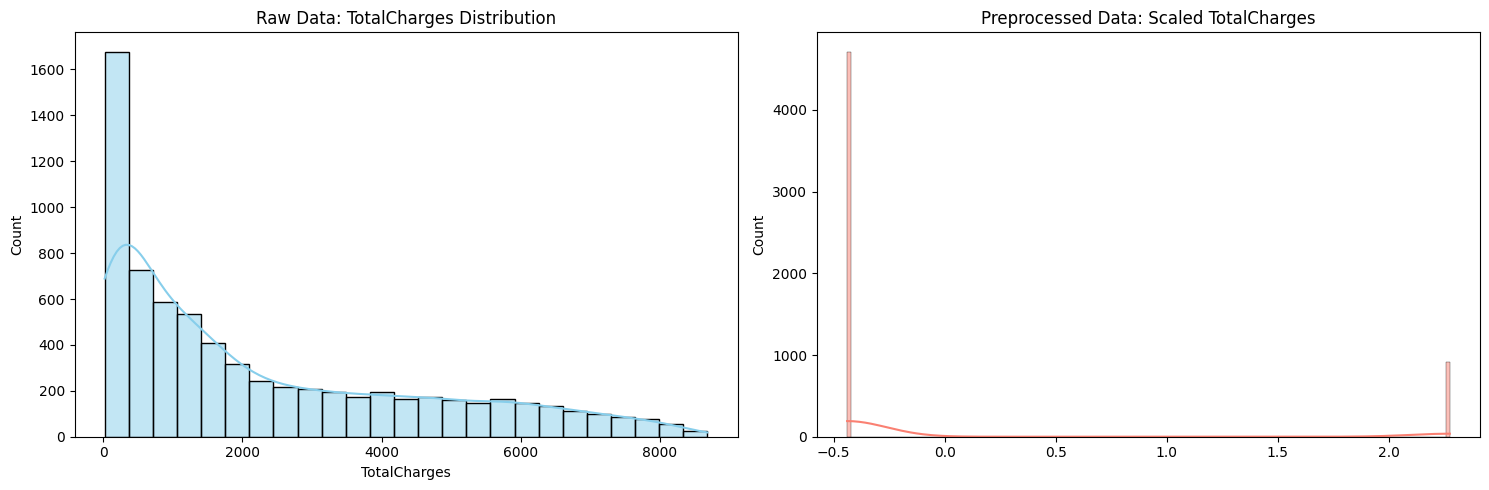


--- 2. Training and Hyperparameter Tuning ---
Training Logistic Regression...


C:\Users\syedm\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Random Forest...


C:\Users\syedm\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Training Deep Learning MLP...


C:\Users\syedm\AppData\Roaming\Python\Python312\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\syedm\AppData\Roaming\Python\Python312\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



|                     |       F1 |   ROC AUC |   Accuracy |
|:--------------------|---------:|----------:|-----------:|
| Logistic Regression | 0.606925 |  0.835134 |   0.725657 |
| Random Forest       | 0.62037  |  0.832012 |   0.76688  |
| Deep Learning MLP   | 0.607362 |  0.833711 |   0.727079 |


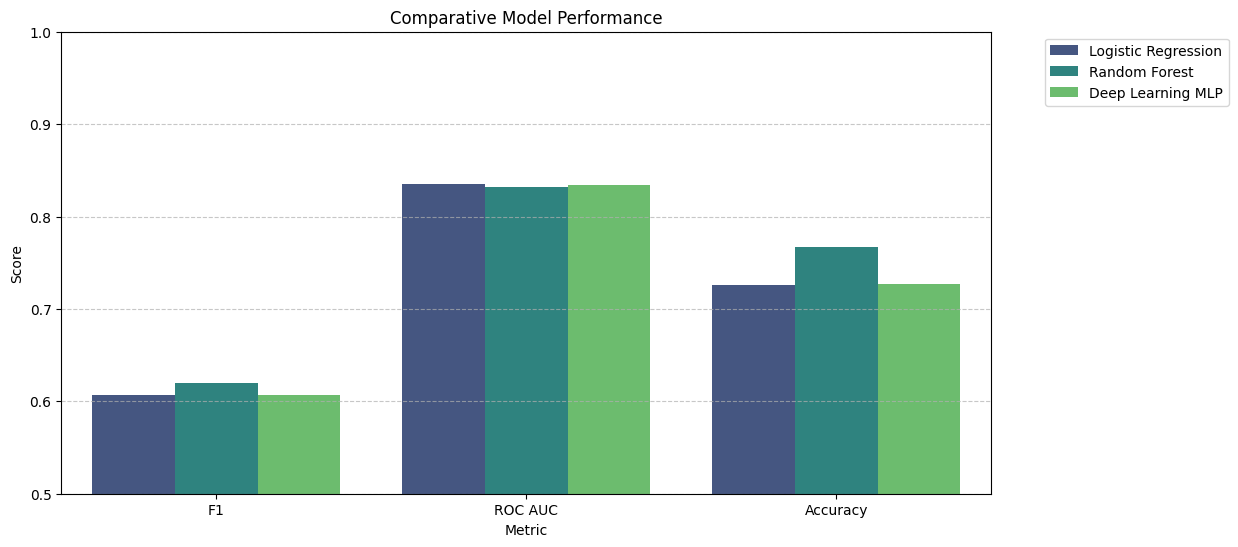

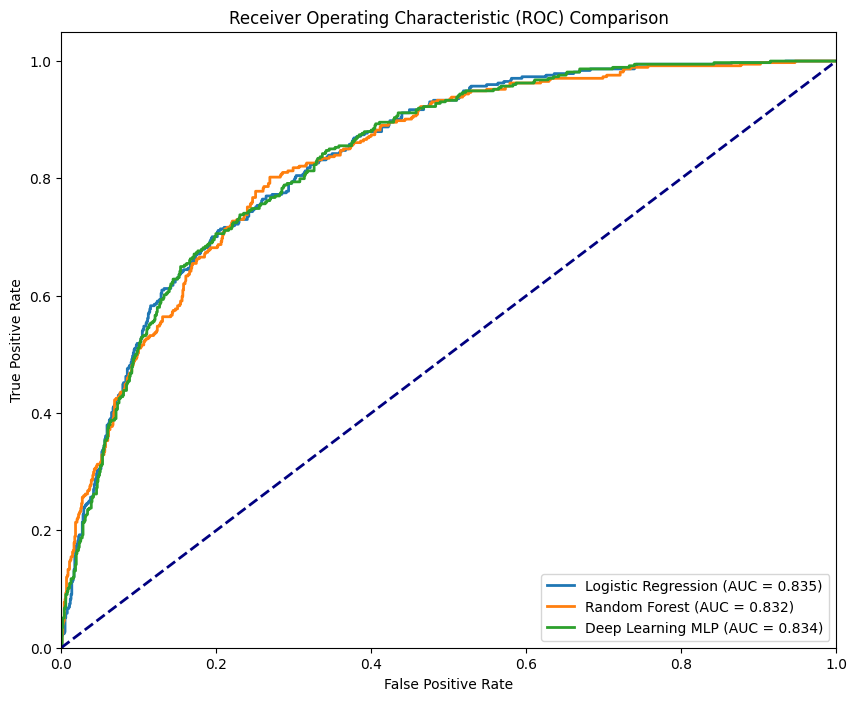

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, f1_score, 
                             roc_auc_score, roc_curve, auc)
import joblib

# PyTorch and skorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetClassifier

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# --- 1. Data Loading and Preprocessing ---
def load_and_preprocess_data():
    url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
    df = pd.read_csv(url)
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df = df.drop('customerID', axis=1)
    df = df.dropna()
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
    return df

def create_preprocessing_pipeline(X):
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    return preprocessor

# --- 2. Visualization Functions ---

def visualize_data_transformation(df_raw, preprocessor, X_train):
    """
    Visualizes the effect of preprocessing on the 'TotalCharges' distribution.
    """
    # Get processed data for visualization
    X_transformed = preprocessor.fit_transform(X_train)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Before Preprocessing
    sns.histplot(df_raw['TotalCharges'], kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title('Raw Data: TotalCharges Distribution')
    
    # After Preprocessing (The first column in 'num' is usually TotalCharges based on column order)
    # Note: ColumnTransformer order depends on how numerical_features list was created
    sns.histplot(X_transformed[:, 0], kde=True, ax=axes[1], color='salmon')
    axes[1].set_title('Preprocessed Data: Scaled TotalCharges')
    
    plt.tight_layout()
    plt.show()



def plot_performance_metrics(results_df):
    """
    Creates a grouped bar chart for F1, Accuracy, and ROC AUC.
    """
    # Melt the dataframe for seaborn
    plot_df = results_df.reset_index().rename(columns={'index': 'Model'})
    plot_df = plot_df.melt(id_vars='Model', value_vars=['F1', 'ROC AUC', 'Accuracy'], 
                           var_name='Metric', value_name='Score')

    plt.figure(figsize=(12, 6))
    sns.barplot(data=plot_df, x='Metric', y='Score', hue='Model', palette='viridis')
    plt.title('Comparative Model Performance')
    plt.ylim(0.5, 1.0) # Focus on the competitive range
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()



def plot_all_roc_curves(roc_data, y_test):
    """
    Plots ROC curves for all models on one graph.
    """
    plt.figure(figsize=(10, 8))
    
    for model_name, y_prob in roc_data.items():
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')
        
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Comparison')
    plt.legend(loc="lower right")
    plt.show()



# --- 3. Deep Learning Model Definition (Unchanged) ---
class ChurnMLP(nn.Module):
    def __init__(self, num_features=None, num_units=100, dropout_rate=0.5):
        super().__init__()
        if num_features is None: num_features = 30 
        self.layer1 = nn.Linear(num_features, num_units)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.layer2 = nn.Linear(num_units, num_units // 2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.layer3 = nn.Linear(num_units // 2, 1)

    def forward(self, X):
        X = X.float() 
        X = self.dropout1(torch.relu(self.layer1(X)))
        X = self.dropout2(torch.relu(self.layer2(X)))
        return self.layer3(X)

# --- 4. Main Execution ---
def main_with_viz():
    print("--- 1. Data Loading and Preprocessing ---")
    df = load_and_preprocess_data()
    X = df.drop('Churn', axis=1)
    y = df['Churn'].values.astype(np.float32).reshape(-1, 1)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y
    )

    preprocessor = create_preprocessing_pipeline(X)
    
    # Visualizing data transformation
    visualize_data_transformation(df, preprocessor, X_train)

    # Determine features for DL
    X_train_processed = preprocessor.fit_transform(X_train)
    num_features = X_train_processed.shape[1]

    neg_count = np.sum(y_train == 0)
    pos_count = np.sum(y_train == 1)
    pos_weight = torch.tensor([neg_count / pos_count], dtype=torch.float32)

    dl_model = NeuralNetClassifier(
        ChurnMLP,
        module__num_features=num_features,
        criterion=nn.BCEWithLogitsLoss, 
        optimizer=optim.Adam,
        max_epochs=20,
        iterator_train__shuffle=True,
        verbose=0,
        criterion__pos_weight=pos_weight
    )

    models = {
        'Logistic Regression': {
            'model': LogisticRegression(random_state=SEED, class_weight='balanced', max_iter=1000),
            'params': {'classifier__C': [0.1, 1, 10]}
        },
        'Random Forest': {
            'model': RandomForestClassifier(random_state=SEED, class_weight='balanced'),
            'params': {'classifier__n_estimators': [100], 'classifier__max_depth': [10]}
        },
        'Deep Learning MLP': {
            'model': dl_model,
            'params': {
                'classifier__module__num_units': [50, 100],
                'classifier__lr': [0.001]
            }
        }
    }

    results = {}
    roc_curves_data = {}
    y_test_flat = y_test.ravel()

    print("\n--- 2. Training and Hyperparameter Tuning ---")
    
    for model_name, model_info in models.items():
        print(f"Training {model_name}...")
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model_info['model'])])
        grid_search = GridSearchCV(pipeline, model_info['params'], cv=3, scoring='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        y_pred = grid_search.predict(X_test)
        
        # Probabilities for ROC
        if hasattr(grid_search.best_estimator_.named_steps['classifier'], 'predict_proba'):
             y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
        else:
             y_pred_proba = grid_search.best_estimator_.predict_proba(X_test).ravel()
        
        roc_curves_data[model_name] = y_pred_proba
        
        results[model_name] = {
            'F1': f1_score(y_test_flat, y_pred),
            'ROC AUC': roc_auc_score(y_test_flat, y_pred_proba),
            'Accuracy': accuracy_score(y_test_flat, y_pred)
        }

    # Display results and graphs
    results_df = pd.DataFrame(results).T
    print("\n" + results_df.to_markdown())

    # --- Comprehensive Visualization ---
    plot_performance_metrics(results_df)
    plot_all_roc_curves(roc_curves_data, y_test_flat)

if __name__ == "__main__":
    main_with_viz()